In [1]:
import EOSutils as meos

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.style.use('classic')

from astropy.table import Table
from astropy import units as u
from astropy.constants import G

import mesa_helper as mh
import os
import shutil
import copy

from scipy import interpolate, optimize
from scipy.linalg import lstsq as scipy_lstsq
from scipy.ndimage import gaussian_filter
import scipy.integrate as integrate
import decimal 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# experimental Hugoniot measurements to plot

In [2]:
# H2 
sources_H2 = ['./H2_nellis+1983.dat','./H2_loubeyre+2012.dat','./H2_brygoo+2015.dat']
labels_H2 = [r'Nellis+1983 H$_2$', r'Loubeyre+2012 H$_2$', r'Brygoo+2015 H$_2$']
edgecolors_H2 = ['Aqua','Salmon','Fuchsia']
facecolors_H2 = ['Aqua','Salmon','Fuchsia']
markers_H2 = ['o','o','o']

# D2

sources_D2 = ['./D2_nellis+1983.dat','./D2_collins+1998.dat','./D2_belov+2002.dat','./D2_boriskov+2003.dat','./D2_grishechkin+2004.dat','./D2_boriskov+2005.dat','./D2_knudson+2004_via_knudson+2009.dat','./D2_hicks+2009_via_knudson+2009.dat','./D2_loubeyre+2012.dat','./D2_brygoo+2015.dat']
labels_D2 = ['Nellis+1983','Collins+1998','Belov+2002','Boriskov+2003','Grishechkin+2004','Boriskov+2005','Knudson+2004,2009','Hicks+2009','Loubeyre+2012','Brygoo+2015']
edgecolors_D2 = ['Aqua','LightSlateGrey','MediumVioletRed','Navy','Lime','Maroon','Black','DarkViolet','Salmon','Fuchsia']
markers_D2 = ['o','o','+','x','*','x','s','s','^','^']

# He
sources_He = ['./He_nellis+1984.dat','./He_eggert+2008.dat','./He_brygoo+2015.dat']
labels_He = ['Nellis+1984','Eggert+2008','Brygoo+2015']
facecolors_He = ['Aqua','Red','DarkViolet',]
edgecolors_He = ['Aqua','Red','DarkViolet']
markers_He = ['^','s','s']

# Hugoniot curves calculated from EoS tables

In [25]:
H_CMS19_Trho = np.genfromtxt("./eos_hugoniot_CMS19_H_Trho.txt")
He_CMS19_Trho = np.genfromtxt("./eos_hugoniot_CMS19_He_Trho.txt")

H_CMS19_TP = np.genfromtxt("./eos_hugoniot_CMS19_H_TP.txt")
He_CMS19_TP = np.genfromtxt("./eos_hugoniot_CMS19_He_TP.txt")

H_SCVH = np.genfromtxt("./eos_hugoniot_SCVH_H_TP.txt")
He_SCVH = np.genfromtxt("./eos_hugoniot_SCVH_He_TP.txt")

tc_H_CMS19_s1 = np.genfromtxt("./eos_hugoniot_tc_CMS19_H_smoothing=1.txt")
tc_He_CMS19_s1 = np.genfromtxt("./eos_hugoniot_tc_CMS19_He_smoothing=1.txt")

tc_H_CMS19_s5 = np.genfromtxt("./eos_hugoniot_tc_CMS19_H_smoothing=5.txt")
tc_He_CMS19_s5 = np.genfromtxt("./eos_hugoniot_tc_CMS19_He_smoothing=5.txt")

tc_H_CMS19_s10 = np.genfromtxt("./eos_hugoniot_tc_CMS19_H_smoothing=10.txt")
tc_He_CMS19_s10 = np.genfromtxt("./eos_hugoniot_tc_CMS19_He_smoothing=10.txt")

# don't plot high-P points or points that didn't numerically converge
# H
H_CMS19_Trho_mask = (H_CMS19_Trho[:,0] <= 7)  & (H_CMS19_Trho[:,1] <= 300)
H_CMS19_Trho = H_CMS19_Trho[H_CMS19_Trho_mask]

H_CMS19_TP_mask = ~((H_CMS19_TP[:,0] <= 2)  & (H_CMS19_TP[:,1] <= 300) & (H_CMS19_TP[:,1] >= 10)) & (H_CMS19_TP[:,1] <= 300)
H_CMS19_TP = H_CMS19_TP[H_CMS19_TP_mask]

H_SCVH_mask = (H_SCVH[:,1] <= 350)
H_SCVH = H_SCVH[H_SCVH_mask]

tc_H_CMS19_s1_mask = (tc_H_CMS19_s1[:,0] <= 5) & (tc_H_CMS19_s1[:,1] <= 300) & ~((tc_H_CMS19_s1[:,1] >= 3) & (tc_H_CMS19_s1[:,0] <= 2.5))
tc_H_CMS19_s1 = tc_H_CMS19_s1[tc_H_CMS19_s1_mask]

tc_H_CMS19_s5_mask = (tc_H_CMS19_s5[:,0] <= 6) & (tc_H_CMS19_s5[:,1] <= 300)
tc_H_CMS19_s5 = tc_H_CMS19_s5[tc_H_CMS19_s5_mask]

tc_H_CMS19_s10_mask = (tc_H_CMS19_s10[:,0] <= 6) & (tc_H_CMS19_s10[:,1] <= 300)
tc_H_CMS19_s10 = tc_H_CMS19_s10[tc_H_CMS19_s10_mask]

#He
He_CMS19_Trho_mask = ~((He_CMS19_Trho[:,0] >= 3)  & (He_CMS19_Trho[:,1] <= 5)) & (He_CMS19_Trho[:,1] <= 300) & (He_CMS19_Trho[:,0] <= 7)
He_CMS19_Trho = He_CMS19_Trho[He_CMS19_Trho_mask]

He_CMS19_TP_mask = ~((He_CMS19_TP[:,0] >=3)  & (He_CMS19_TP[:,1] <= 5)) & (He_CMS19_TP[:,1] <= 300)
He_CMS19_TP = He_CMS19_TP[He_CMS19_TP_mask]

He_SCVH_mask = (He_SCVH[:,1] <= 350)
He_SCVH = He_SCVH[He_SCVH_mask]

tc_He_CMS19_s1_mask = (tc_He_CMS19_s1[:,0] <= 6) & (tc_He_CMS19_s1[:,1] <= 300) & ~((tc_He_CMS19_s1[:,0] > 3) & (tc_He_CMS19_s1[:,1] < 10)) 
tc_He_CMS19_s1 = tc_He_CMS19_s1[tc_He_CMS19_s1_mask]

tc_He_CMS19_s5_mask = (tc_He_CMS19_s5[:,0] <= 6) & (tc_He_CMS19_s5[:,1] <= 300)
tc_He_CMS19_s5 = tc_He_CMS19_s5[tc_He_CMS19_s5_mask]

tc_He_CMS19_s10_mask = (tc_He_CMS19_s10[:,0] <= 6) & (tc_He_CMS19_s10[:,1] <= 300) & ~((tc_He_CMS19_s10[:,0] >= 2.5) & (tc_He_CMS19_s10[:,1]<=5)) & ~((tc_He_CMS19_s10[:,0] >= 1) & (tc_He_CMS19_s10[:,1]<=2))
tc_He_CMS19_s10 = tc_He_CMS19_s10[tc_He_CMS19_s10_mask]

# sort
H_CMS19_Trho = H_CMS19_Trho[np.argsort(H_CMS19_Trho[:,1])]
H_CMS19_TP = H_CMS19_TP[np.argsort(H_CMS19_TP[:,1])]
H_SCVH = H_SCVH[np.argsort(H_SCVH[:,1])]
tc_H_CMS19_s1 = tc_H_CMS19_s1[np.argsort(tc_H_CMS19_s1[:,1])]
tc_H_CMS19_s5 = tc_H_CMS19_s5[np.argsort(tc_H_CMS19_s5[:,1])]
tc_H_CMS19_s10 = tc_H_CMS19_s10[np.argsort(tc_H_CMS19_s10[:,1])]

He_CMS19_Trho = He_CMS19_Trho[np.argsort(He_CMS19_Trho[:,1])]
He_CMS19_TP = He_CMS19_TP[np.argsort(He_CMS19_TP[:,1])]
He_SCVH = He_SCVH[np.argsort(He_SCVH[:,1])]
tc_He_CMS19_s1 = tc_He_CMS19_s1[np.argsort(tc_He_CMS19_s1[:,1])]
tc_He_CMS19_s5 = tc_He_CMS19_s5[np.argsort(tc_He_CMS19_s5[:,1])]
tc_He_CMS19_s10 = tc_He_CMS19_s10[np.argsort(tc_He_CMS19_s10[:,1])]

# plot theoretical against experimental

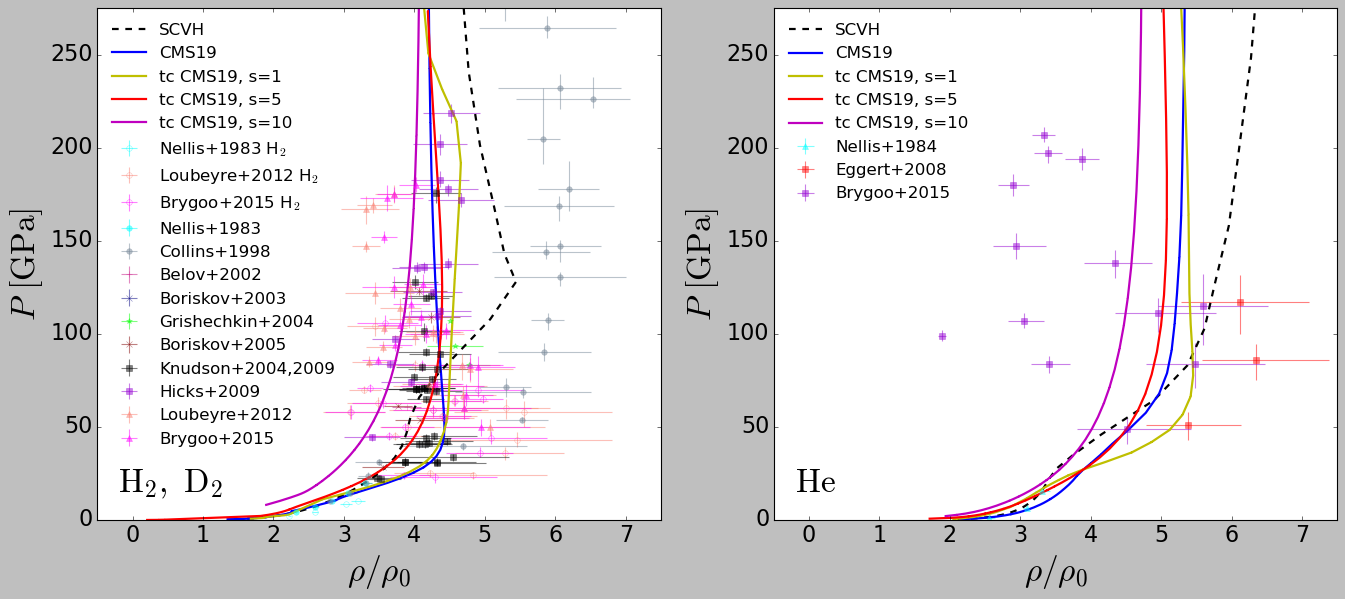

In [39]:
fig, axes = plt.subplots(1,2,figsize=(20,8))

ms = 5
expalpha=0.5
lw=2

for i in range(len(sources_H2)):
    data = Table.read(sources_H2[i],format="ascii")
    xerr = np.vstack((data['eta_unc_lower[unitless]'],data['eta_unc_upper[unitless]']))
    yerr =  np.vstack((data['P_unc_lower[GPa]'],data['P_unc_upper[GPa]']))
    axes[0].errorbar(x=data['eta[unitless]'],y=data['P[GPa]'],xerr=xerr,yerr=yerr,marker=markers_H2[i],ms=ms,markeredgecolor=edgecolors_H2[i],markerfacecolor='None',linestyle='None',elinewidth=1,ecolor=edgecolors_H2[i],label=labels_H2[i],capsize=0,alpha=expalpha)

for i in range(len(sources_D2)):        
    if 'collins' in sources_D2[i] or 'grishechkin' in sources_D2[i] or 'knudson' in sources_D2[i]:
        data = Table.read(sources_D2[i],format="ascii",header_start=1)
    else:
        data = Table.read(sources_D2[i],format="ascii")
    xerr = np.vstack((data['eta_unc_lower[unitless]'],data['eta_unc_upper[unitless]']))
    yerr =  np.vstack((data['P_unc_lower[GPa]'],data['P_unc_upper[GPa]']))
    axes[0].errorbar(x=data['eta[unitless]'],y=data['P[GPa]'],xerr=xerr,yerr=yerr,marker=markers_D2[i],ms=ms,markeredgecolor=edgecolors_D2[i],markerfacecolor=edgecolors_D2[i],linestyle='None',elinewidth=1,ecolor=edgecolors_D2[i],label=labels_D2[i],capsize=0,alpha=expalpha)

for i in range(len(sources_He)):
    data = Table.read(sources_He[i],format="ascii")
    xerr = np.vstack((data['eta_unc_lower[unitless]'],data['eta_unc_upper[unitless]']))
    yerr =  np.vstack((data['P_unc_lower[GPa]'],data['P_unc_upper[GPa]']))
    axes[1].errorbar(x=data['eta[unitless]'],y=data['P[GPa]'],xerr=xerr,yerr=yerr,marker=markers_He[i],ms=ms,markeredgecolor=edgecolors_He[i],markerfacecolor=facecolors_He[i],linestyle='None',elinewidth=1,ecolor=edgecolors_He[i],label=labels_He[i],capsize=0,alpha=expalpha)

axes[0].plot(H_SCVH[:,0],H_SCVH[:,1], 'k--', lw=lw,label='SCVH')
axes[1].plot(He_SCVH[:,0],He_SCVH[:,1], 'k--', lw=lw, label='SCVH')

axes[0].plot(H_CMS19_Trho[:,0],H_CMS19_Trho[:,1], 'b-', lw=lw,label='CMS19')
axes[1].plot(He_CMS19_Trho[:,0],He_CMS19_Trho[:,1], 'b-',lw=lw, label='CMS19')

axes[0].plot(tc_H_CMS19_s1[:,0],tc_H_CMS19_s1[:,1], 'y-', lw=lw,label='tc CMS19, s=1')
axes[1].plot(tc_He_CMS19_s1[:,0],tc_He_CMS19_s1[:,1], 'y-', lw=lw, label='tc CMS19, s=1')

axes[0].plot(tc_H_CMS19_s5[:,0],tc_H_CMS19_s5[:,1], 'r-', lw=lw,label='tc CMS19, s=5')
axes[1].plot(tc_He_CMS19_s5[:,0],tc_He_CMS19_s5[:,1], 'r-', lw=lw, label='tc CMS19, s=5')

axes[0].plot(tc_H_CMS19_s10[:,0],tc_H_CMS19_s10[:,1], 'm-', lw=lw,label='tc CMS19, s=10')
axes[1].plot(tc_He_CMS19_s10[:,0],tc_He_CMS19_s10[:,1], 'm-', lw=lw, label='tc CMS19, s=10')

for ax in axes:
    ax.set_xlabel(r'$\rho/\rho_0$',fontsize=30)
    ax.set_ylabel(r'$P\ \mathrm{[GPa]}$',fontsize=30)
    ax.set_xlim(-0.5,7.5)
    ax.set_ylim(0,275)
    #ax.set_ylim(0,50)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.legend(loc='upper left',frameon=False,numpoints=1,fontsize=15)

axes[0].text(x=-0.2,y=15,s=r'$\mathrm{H}_2,\ \mathrm{D}_2$',fontsize=30)
#axes[0].text(x=1,y=25,s=r'$\mathrm{D}_2$',fontsize=30)

axes[1].text(x=-0.2,y=15,s=r'$\mathrm{He}$',fontsize=30)


plt.show()
#plt.savefig("hugoniots_lowPzoom.pdf",bbox_inches='tight')